In [1]:
using Pkg
Pkg.activate("../.")

Activating environment at `~/Documents/Code/julia/GP/GP_model_zoo/Project.toml`


In [2]:
using Stheno
using Flux
using Zygote
using Plots
pyplot()
using Random; Random.seed!(5);

┌ Info: Precompiling Stheno [8188c328-b5d6-583d-959b-9690869a5511]
└ @ Base loading.jl:1273
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1273
┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/hongbinren/.julia/packages/CUDAdrv/b1mvw/src/CUDAdrv.jl:67


# Neural network + Gaussian process ( step function )
## Introduction
Gaussian process is typically used as a smoothing device, here, we show that by combining with a simple fully connected neural network, it's able to correctly learn sharp discontinuities.

Targeted function:
$$
\begin{gather}
y=F(x)+\epsilon,\;\epsilon\sim\mathcal{N}(0, 0.01^2)\\
F(x)=\left\{\begin{array}{rl}
    0.0 & \text{if } x\le0.0\\
    1.0 & \text{if } x>0.0
    \end{array}\right.
\end{gather}
$$

Neural network is used as a feature extractor, it can be viewed as a nonlinear transformation $T:\,x\to z$, Gaussian process with Automatic Relevance Determination (ARD) kernel is then used to map $z\to y$, the combined mapping can be represented as $y=f(T(x))$.

In [3]:
step_func(x) = (ϵ=0.01*randn(); x>0.0 ? 1.0+ϵ : 0.0+ϵ)

# prepare data
## training data, drawn from N(0, 1)
train_X = randn(100); Xtrain = reshape(train_X, 1, :)
train_y = step_func.(train_X)

## test data drawn uniformly from U(-5, 5)
test_X = Array(-5.0:0.02:5.0); Xtest = reshape(test_X, 1, :)
test_y = step_func.(test_X);

In [4]:
# build a MLP that perform domain transformation to the input data
mlp = Chain(Dense(1, 6, relu), Dense(6, 2, relu)) |> f64
θ_mlp = params(mlp)

# build a GP model with Stheno
logl = randn(2)
logγ = [0.0]
logλ = [0.01]

function build_gp(logl, logγ)
    ard_se_kernel = exp(2.0*logγ[1])*stretch(EQ(), exp.(-logl))
    gp = GP(ard_se_kernel, GPC())
    gp
end

# collect parameters for NNGP
ps = Params([logl, logγ, logλ, θ_mlp...]);

In [5]:
# Use negative log-likelihood as objective function
function NLL(X, y)
    Z = mlp(X)
    gp = build_gp(logl, logγ)
    margin_lik = gp(ColVecs(Z), exp(2.0*logλ[1]))
    nll = -logpdf(margin_lik, y)
    nll
end

NLL (generic function with 1 method)

In [6]:
# Use Flux's trainer for training
using Flux.Optimise: update!

train_data = (Xtrain, train_y)
opt = ADAGrad()
nlls = []
for i in 1:1500
    nll = NLL(train_data...)
    push!(nlls, nll)
    gs = gradient(()->NLL(train_data...), ps)
    for p in ps
        update!(opt, p, gs[p])
    end
end

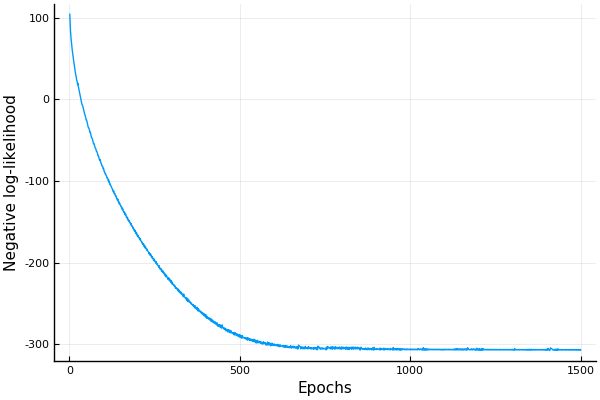

In [7]:
plot(nlls, xlabel="Epochs", ylabel="Negative log-likelihood", legend=false)

In [8]:
# Use GP posterior to predict
function predict(X, Xtrain, ytrain)
    Z = mlp(X); Ztrain = mlp(Xtrain)
    gp = build_gp(logl, logγ)
    noisy_prior = gp(ColVecs(Ztrain), exp(2.0*logλ[1]))
    posterior = gp | Obs(noisy_prior, ytrain)
    posterior(ColVecs(Z))
end

posterior = predict(Xtest, Xtrain, train_y)
post_dist = marginals(posterior)
pred_y = mean.(post_dist)
var_y = std.(post_dist);

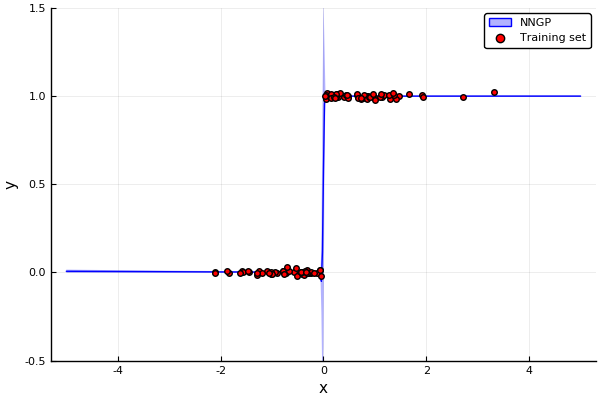

In [9]:
plt = plot()
plot!(plt, test_X, pred_y, ribbons=3*var_y, st=:line, fillalpha=0.3, color=:blue, label="NNGP")
plot!(plt, train_X, train_y, st=:scatter, color=:red, lw=5, label="Training set")
plot!(plt, xlabel="x", ylabel="y", ylim=(-0.5,1.5))

## Reference
[1] [Deep kernel learning](https://arxiv.org/abs/1511.02222)

[2] [Manifold Gaussian Processes for Regression](https://arxiv.org/abs/1402.5876)